# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [3]:
import torch
from torchvision import datasets, transforms

In [4]:
x = datasets.MNIST('data', download=True)
x[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [6]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [7]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

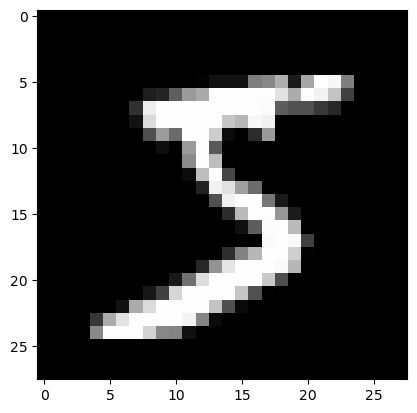

In [9]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

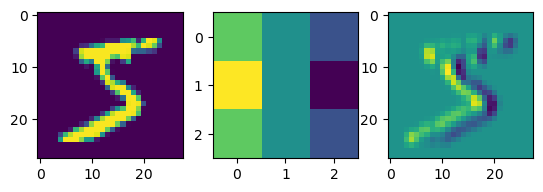

In [10]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [13]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_7191/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [14]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

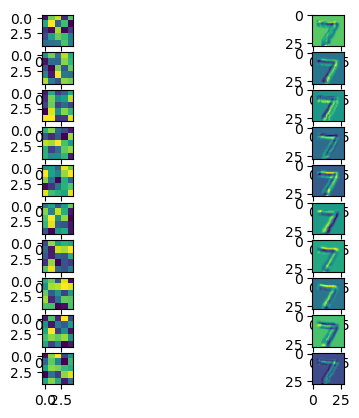

In [15]:
visualize()

# Predict Using Network

In [16]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [17]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_7191/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([8, 9, 8, 1, 8])

# First Test and Train

In [18]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [19]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_7191/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 10%



In [20]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [21]:
train()

Train loss: 2.297973


/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_7191/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.136438
Train loss: 1.477590
Train loss: 0.901470
Train loss: 0.843441
Train loss: 0.650546
Train loss: 0.533117
Train loss: 0.640189
Train loss: 0.502836
Train loss: 0.624400


# Train Network

In [22]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_7191/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.330826
Train loss: 1.780661
Train loss: 0.993699
Train loss: 0.840183
Train loss: 0.646944
Train loss: 0.717944
Train loss: 0.336504
Train loss: 0.478339
Train loss: 0.704116
Train loss: 0.574541
Test accuracy: 95%

Train loss: 0.275206
Train loss: 0.536917
Train loss: 0.350725
Train loss: 0.379119
Train loss: 0.261461
Train loss: 0.282317
Train loss: 0.337328
Train loss: 0.492986
Train loss: 0.369962
Train loss: 0.304484
Test accuracy: 96%

Train loss: 0.197759
Train loss: 0.173739
Train loss: 0.220648
Train loss: 0.611087
Train loss: 0.199316
Train loss: 0.299830
Train loss: 0.402084
Train loss: 0.301065
Train loss: 0.278392
Train loss: 0.409042
Test accuracy: 97%

Train loss: 0.258547
Train loss: 0.240860
Train loss: 0.156197
Train loss: 0.477006
Train loss: 0.348973
Train loss: 0.400522
Train loss: 0.243910
Train loss: 0.209298
Train loss: 0.885771
Train loss: 0.362778
Test accuracy: 97%

Train loss: 0.164566
Train loss: 0.167435
Train loss: 0.274191
Train loss: 0.449

# Inspect Network

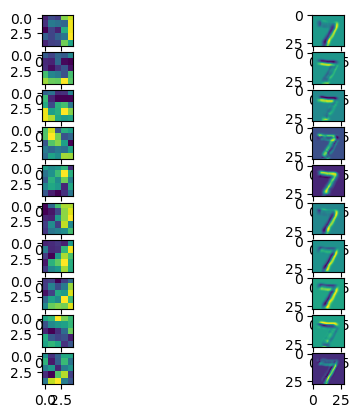

In [23]:
visualize()

In [24]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [25]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_7191/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [26]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [27]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_7191/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.361669
Train loss: 1.756693
Train loss: 0.896676
Train loss: 0.850987
Train loss: 0.646673
Train loss: 0.600259
Train loss: 0.478490
Train loss: 0.618953
Train loss: 0.413666
Train loss: 0.442580
Test accuracy: 95%

Train loss: 0.387392
Train loss: 0.344902
Train loss: 0.381227
Train loss: 0.433479
Train loss: 0.383878
Train loss: 0.526149
Train loss: 0.321912
Train loss: 0.502682
Train loss: 0.289387
Train loss: 0.306045
Test accuracy: 97%

Train loss: 0.468971
Train loss: 0.239400
Train loss: 0.277482
Train loss: 0.294908
Train loss: 0.165934
Train loss: 0.314265
Train loss: 0.252053
Train loss: 0.421840
Train loss: 0.259653
Train loss: 0.257650
Test accuracy: 97%

Train loss: 0.282991
Train loss: 0.223891
Train loss: 0.218379
Train loss: 0.264912
Train loss: 0.288577
Train loss: 0.257642
Train loss: 0.227567
Train loss: 0.312513
Train loss: 0.424010
Train loss: 0.318703
Test accuracy: 98%

Train loss: 0.180257
Train loss: 0.205147
Train loss: 0.213962
Train loss: 0.252

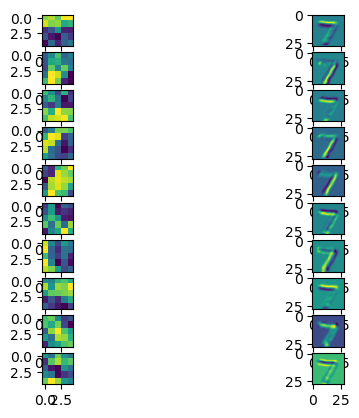

In [28]:
visualize()

# Using 600 images
- The accuracy is not good (13%, 18%, 26%, 33%, 39%)
- The weights look like there is no pattern to them

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_7191/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.292667
Test accuracy: 13%

Train loss: 2.312106
Test accuracy: 18%

Train loss: 2.302408
Test accuracy: 26%

Train loss: 2.249252
Test accuracy: 33%

Train loss: 2.251644
Test accuracy: 39%



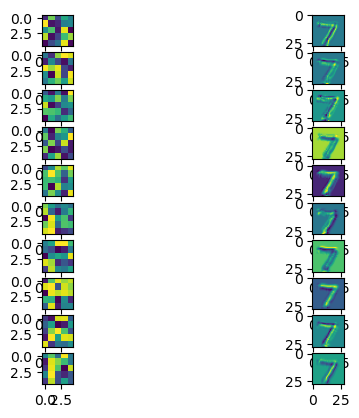

In [29]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

# Using 3,000 images
- Accuracy is better (29%, 49%, 69%, 78%, 82%)

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_7191/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.337049
Test accuracy: 29%

Train loss: 2.270909
Test accuracy: 49%

Train loss: 2.085631
Test accuracy: 69%

Train loss: 1.690811
Test accuracy: 78%

Train loss: 1.409049
Test accuracy: 82%



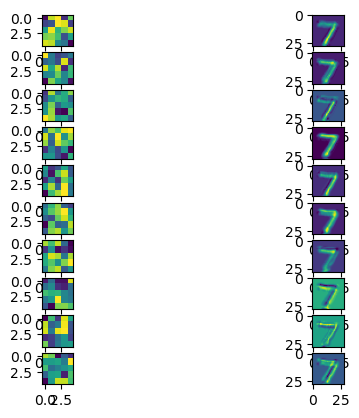

In [30]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

# Using 6,000 images
- Accuracy is better (67%, 84%, 87%, 90%, 91%)

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_7191/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.290599
Test accuracy: 67%

Train loss: 1.690972
Test accuracy: 84%

Train loss: 0.953453
Test accuracy: 87%

Train loss: 0.762132
Test accuracy: 90%

Train loss: 0.681767
Test accuracy: 91%



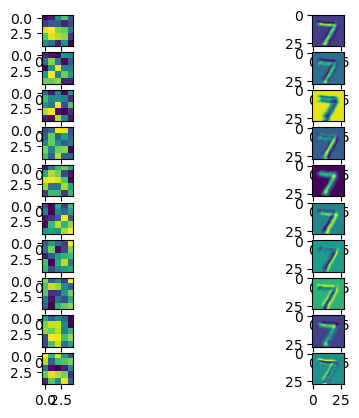

In [31]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

# Using 30,000 images
- Accuracy is better (91%, 94%, 95%, 96%, 97%)

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_7191/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.353259
Train loss: 2.025611
Train loss: 1.253975
Train loss: 0.841348
Train loss: 0.713645
Test accuracy: 91%

Train loss: 0.600109
Train loss: 0.540802
Train loss: 0.579774
Train loss: 0.725853
Train loss: 0.366533
Test accuracy: 94%

Train loss: 0.554023
Train loss: 0.298661
Train loss: 0.322025
Train loss: 0.481825
Train loss: 0.452443
Test accuracy: 95%

Train loss: 0.422917
Train loss: 0.168985
Train loss: 0.390234
Train loss: 0.614072
Train loss: 0.306193
Test accuracy: 96%

Train loss: 0.390506
Train loss: 0.222861
Train loss: 0.267370
Train loss: 0.279593
Train loss: 0.226426
Test accuracy: 97%



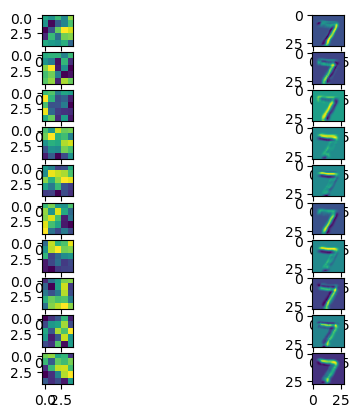

In [32]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

# Using 60,000 images
- Accuracy is the best here (94%, 96%, 97%, 97%, 98%)
- The weights look like they have more of a clustering pattern to them compared to 600 images

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_7191/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.316344
Train loss: 1.594079
Train loss: 1.098044
Train loss: 0.838901
Train loss: 0.686163
Train loss: 0.633439
Train loss: 0.516647
Train loss: 0.607713
Train loss: 0.682129
Train loss: 0.594483
Test accuracy: 94%

Train loss: 0.403460
Train loss: 0.426283
Train loss: 0.425931
Train loss: 0.406197
Train loss: 0.330205
Train loss: 0.445977
Train loss: 0.228560
Train loss: 0.468822
Train loss: 0.387838
Train loss: 0.362901
Test accuracy: 96%

Train loss: 0.280595
Train loss: 0.264714
Train loss: 0.234412
Train loss: 0.553562
Train loss: 0.202256
Train loss: 0.362661
Train loss: 0.297042
Train loss: 0.353508
Train loss: 0.482235
Train loss: 0.499599
Test accuracy: 97%

Train loss: 0.259562
Train loss: 0.285037
Train loss: 0.232512
Train loss: 0.438683
Train loss: 0.246195
Train loss: 0.432853
Train loss: 0.222048
Train loss: 0.377406
Train loss: 0.303888
Train loss: 0.498939
Test accuracy: 97%

Train loss: 0.245024
Train loss: 0.371644
Train loss: 0.161558
Train loss: 0.300

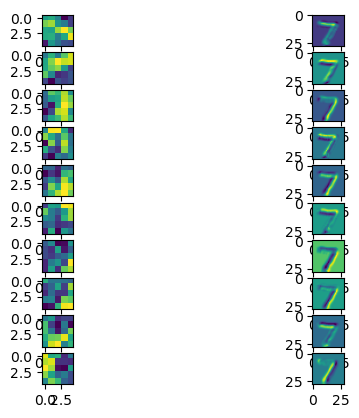

In [33]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()